# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020-23 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

In [1]:
!pip uninstall numpy -y
!pip install numpy==1.22.0

Found existing installation: numpy 1.22.0
Uninstalling numpy-1.22.0:
  Successfully uninstalled numpy-1.22.0
  Using cached numpy-1.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from tqdm import tqdm
from src.invariant_mass import find_invariant_mass
from src.file_reading import read_file
from sklearn.cluster import KMeans

### Input data
This opens input data files and assigns them to variables.

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [3]:

pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (
    master_probpi, master_probk), invariant_mass_array, two_body_resonance = read_file(mode=3, MAX_EVENTS=10, selection=True,
                                                                   interest="B+")


 Selecting B+ events
Input data varaiables: 
Magnet up data
['DecayTree;1']
Varialbes read



KeyboardInterrupt: 

### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 1D histogram


NameError: name 'master_probpi' is not defined

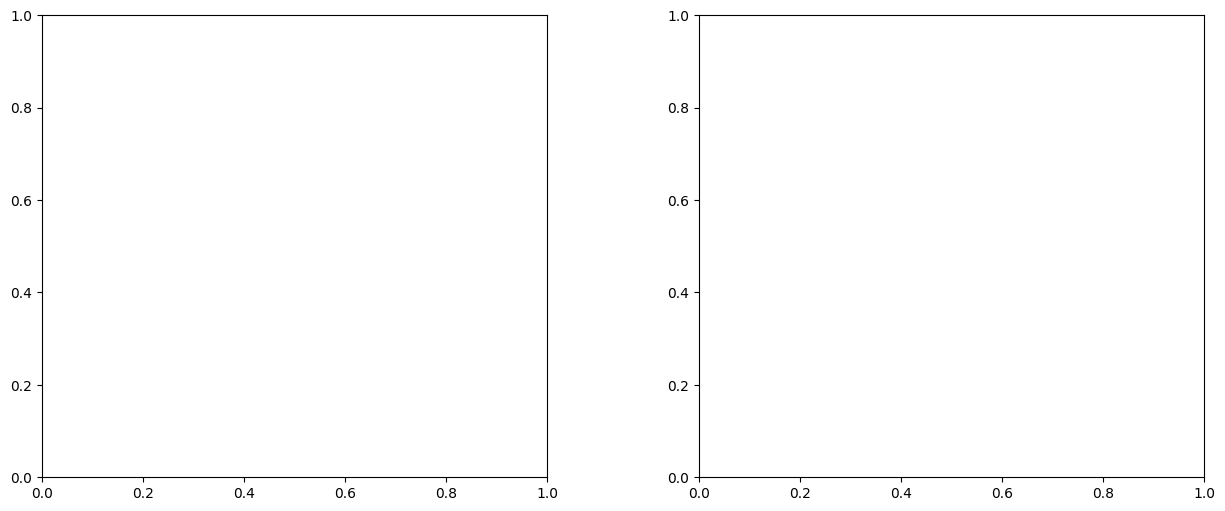

In [2]:
def plotting_histograms_probability(particle=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
    print('Plotting 1D histogram')
    if particle == 1:
        interest_pi = h1_probpi
        interest_k  = h1_probk
    if particle == 2:
        interest_pi = h2_probpi
        interest_k  = h2_probk
    if particle == 3:
        interest_pi = h3_probpi
        interest_k = h3_probk
        
    else:
        interest_pi = master_probpi
        interest_k = master_probk
    values_probpi, bins_probpi, patches_probpi = ax[0].hist(interest_pi, bins=100, range=[0,1], histtype='step', 
                                                             label='$Prob_{particle} Pion$')
    ax[0].hist(interest_k, bins = 100, range = [0, 1],histtype='stepfilled',alpha=0.3,label='$p_{particle} kaon$')
    ax[0].set_xlabel('Probability')
    ax[0].set_ylabel('Entries')
    ax[0].legend()
    
    #plt.savefig(f"Prob Pion vs Kaon Histogram particle{particle}")
    #plt.savefig(f"Prob_kaon_pion_{particle}.pdf")
    
    print('Plotting 2D histogram')
    h2d = ax[1].hist2d(interest_pi, interest_k,
                       bins = [100,100], range = [[0,1],[0,1]],norm=colors.LogNorm())
    ax[1].set_xlabel(f'Probability Pion ')
    ax[1].set_ylabel(f'Probability Kaon ')
    fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
    #plt.savefig(f"Prob_pi_prob_k_{particle}_2d.pdf")
    return values_probpi, bins_probpi, patches_probpi

values_probpi, bins_probpi, patches_probpi = plotting_histograms_probability(particle=
                                                                            None)
    

Plotting 1D histogram


NameError: name 'h3_probpi' is not defined

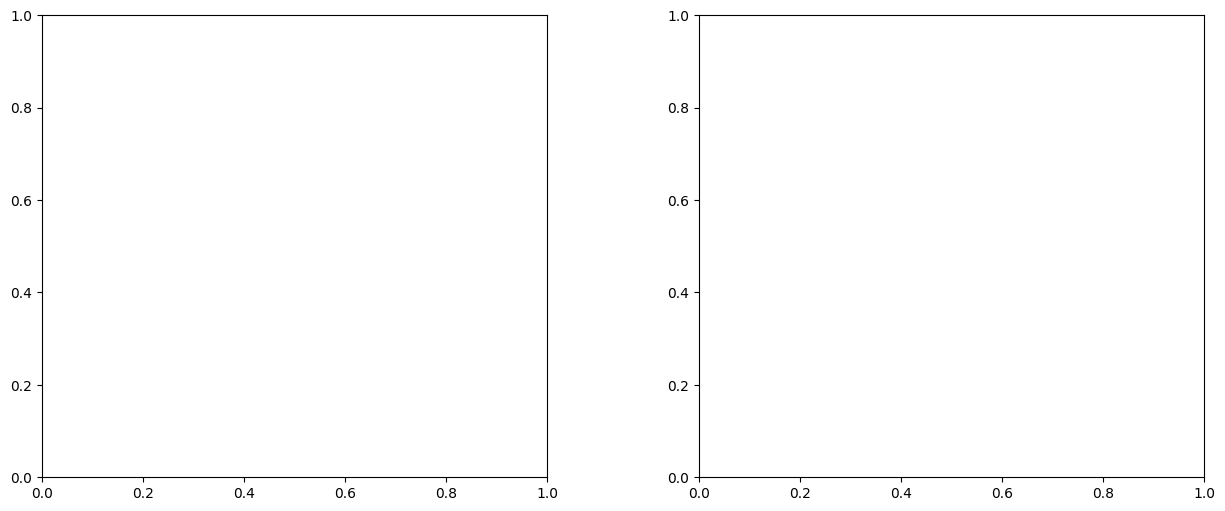

In [3]:
plotting_histograms_probability(3)

## Clustering using SKLEARN

In [ ]:

master_probpi = np.array(master_probpi).flatten()
master_probk  = np.array(master_probk).flatten()
master_probpi = np.expand_dims(master_probpi, axis=1)
master_probk  = np.expand_dims(master_probk, axis=1)
master_probability = np.concatenate((master_probpi, master_probk), axis=1)


In [ ]:
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": [1,2,3,4,5,6],
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(master_probability)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': [1, 2, 3, 4, 5, 6]},
             scoring=<function gmm_bic_score at 0x7f9b72923b80>)

In [ ]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

/home/codespace/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: >

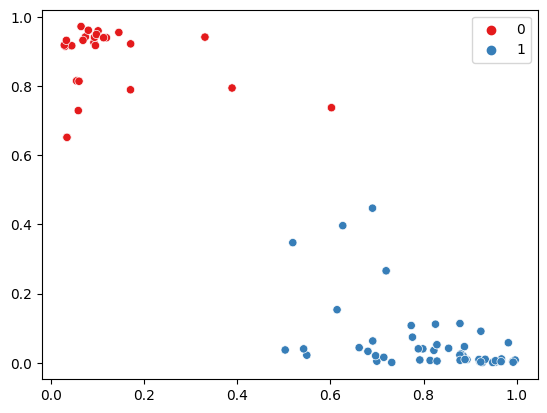

In [ ]:
# fit a kmeans clustering model to the data
kmeans = KMeans(n_clusters=2, random_state=0).fit(master_probability)
#plot the clusters

# SEABORN PLOT OF THE CLUSTERS
import seaborn as sns

# plot the clusters using seaborn 
sns.scatterplot(x=master_probability[:,0], y=master_probability[:,1], hue=kmeans.labels_, palette='Set1')

In [ ]:
#fit a GMM model to the data using EM algorithm#
gmm = GaussianMixture(n_components=2, covariance_type='tied').fit(master_probability)
#plot the clusters
sns.scatterplot(x=master_probability[:,0], y=master_probability[:,1], hue=gmm.predict(master_probability), palette='Set1')
#seaborn set labels
plt.xlabel('Probability Pion')
plt.ylabel('Probability Kaon')
plt.title('GMM Clustering of Pion and Kaon Probabilities')
#plt.scatter(master_probability[:,0], master_probability[:,1], c=gmm.predict(master_probability), cmap='rainbow')

In [ ]:
#get the probabilities of assignment of each point to each cluster
gmm_probs = gmm.predict_proba(master_probability)
#plot the probabilities of assignment of each point to each cluster
# sns.scatterplot(x=master_probability[:,0], y=master_probability[:,1], hue=gmm_probs[:,0], palette='Set1')
# #seaborn set labels
# plt.xlabel('Probability Pion')
# plt.ylabel('Probability Kaon')
# plt.title('GMM Clustering of Pion and Kaon Probabilities')


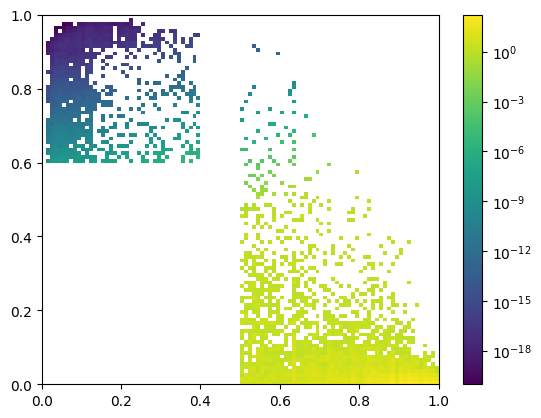

Bad pipe message: %s [b'\xd5\x1a\x8d\xdc\xd0.a\xeef\xdfW\\\xe3\xb1\xf0\xb6\x8a[ \x0c\x85\xed\xeeC\xf6\x17\xd4\xb7#k\x06\xdc\x12\xac\\Z\x05\xc6(\xbd\xe9t\xd0\xffW\xfbg\xd9\xcc\xf9\xc1\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05']
Bad pipe message: %s [b'\x04\x01\x05\x01\x06\x01\x00']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xeb ]\xe6\xed\xd1=\x0f\x9d\xa13R\xd9\x96-\xf0\xf2\xb6]\xfe\xc8\xa4']
Bad pipe message: %s [b';\x8c\x003E\xde\x0c\xacw\xc5\xaa\x88J\xc1\xd4gs\xa0\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x

In [ ]:
np.shape(gmm_probs)
#tkae the differnece between the probabilities of assignment to each cluster
gmm_probs_diff = gmm_probs[:,0] - gmm_probs[:,1];
#gmm_abs = np.abs(gmm_probs_diff)
#plot using a 2d histogram
sns.color_palette("flare", as_cmap=True)

plt.hist2d(master_probability[:,0], master_probability[:,1], bins=100, range=[[0,1],[0,1]], weights=gmm_probs_diff, norm=colors.LogNorm())
plt.hist2d(master_probability[:,0], master_probability[:,1], bins=100, range=[[0,1],[0,1]], weights=gmm_probs[:,0],  norm=colors.LogNorm())
#add a colour bar
plt.colorbar()

#need to fix this, to essnetially show the difference in the probabilities of assignment to each cluster


#plt.hist(gmm_probs_diff, bins=100, range=[-1,1], histtype='step', label='GMM')

Plot the probability of being a pion versus the gmm assignment probability

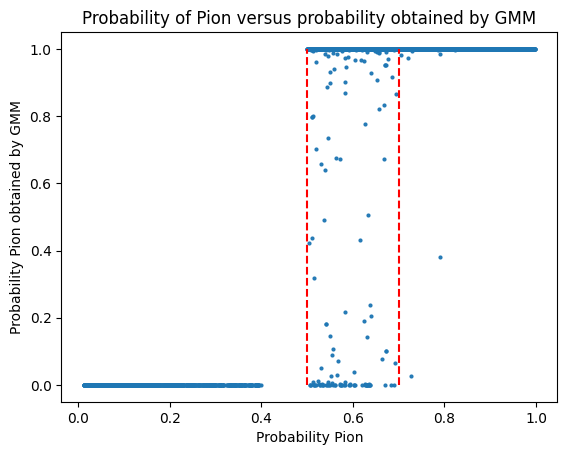

In [57]:
#plt.hist(gmm_probs[:,0], bins=100, range=[0,1], histtype='step', label='GMM')

plt.title("Probability of Pion versus probability obtained by GMM")
plt.plot(master_probability[:,0], gmm_probs[:,0], 'o', markersize=2, label='GMM', alpha=0.95, )
plt.xlabel('Probability Pion')
plt.ylabel('Probability Pion obtained by GMM')
#plot a line at 0.5

plt.plot([0.5,0.5], [0,1], color='red', linestyle='--')
plt.plot([0.7,0.7], [0,1], color='red', linestyle='--')


#plt.plot([0,1],[0,1], color='black', linestyle='--')
#scatter plot of the probabilities of assignment to each cluster



# plt.title("Probability of Kaon versus probability obtained by GMM")
# plt.plot(master_probability[:,1], gmm_probs[:,1], 'o', markersize=1, label='GMM')

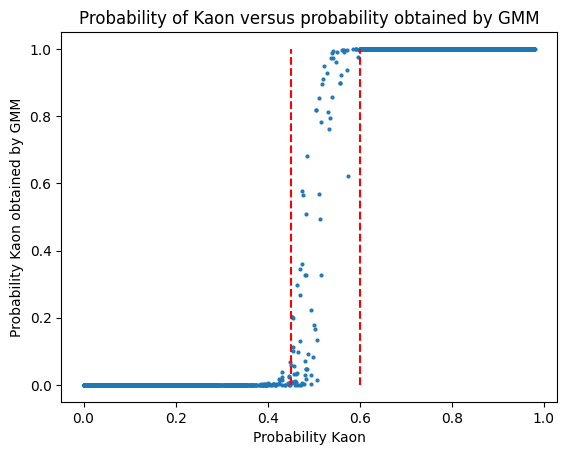

In [61]:
#plotting the same for Kaon
plt.title("Probability of Kaon versus probability obtained by GMM")
plt.plot(master_probability[:,1], gmm_probs[:,1], 'o', markersize=2, label='GMM', alpha=0.95, )
plt.xlabel('Probability Kaon')
plt.ylabel('Probability Kaon obtained by GMM')
#plot a line at 0.5

plt.plot([0.45,0.45], [0,1], color='red', linestyle='--')
plt.plot([0.6,0.6], [0,1], color='red', linestyle='--')

## Cleaning the resonsnaces

In [4]:
from src.clean_background import seperate_background_signal

background, signal = seperate_background_signal()

print("Background: ", background.shape)

/home/codespace/.python/current/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ValueError: too many values to unpack (expected 2)

## Finding Invariant Mass


Invariant Mass for a simulated dataset

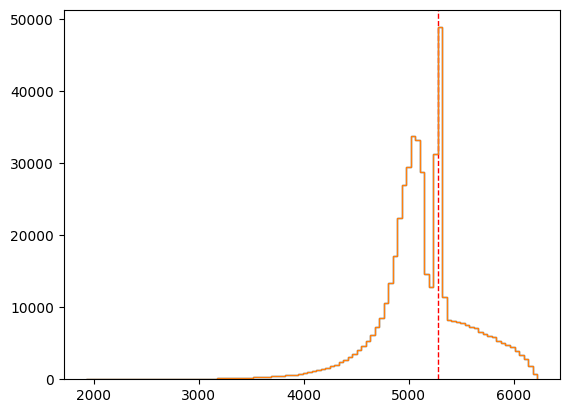

In [3]:
invariant_mass_numpy = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass _second.csv', delimiter=',')
x_data = np.linspace(5100, 5600, 1000)

plt.hist(invariant_mass_numpy, bins=100,  histtype='step', label='Invariant Mass');
plt.axvline(5279, color='r', linestyle='dashed', linewidth=1);
values, bins, patches = plt.hist(invariant_mass_numpy, bins=100,  histtype='step', label='Invariant Mass');

### Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

In [10]:
BIN_NUM = 100

def get_bins(bins, values):
    #get the bin values
    bin_values = np.histogram(values, bins=bins, )
    #get the bin edges
    bin_edges = np.histogram_bin_edges(values, bins=bins)
    #get the bin centres
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    return  bin_centres
def get_bins_values(mode="B+", BINS=100, x_min=5100, x_max=5800, data_generation = 1):

    if mode == "B+":
        dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass_positive.csv', delimiter=',')
    elif mode == "B-":
        dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass_negative.csv', delimiter=',')

    else:
        if data_generation == 1:

            dataset = np.genfromtxt('/workspaces/labs_yr3/data/inv_mass.csv', delimiter=',')
        else:
            dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass _second.csv', delimiter=',')
    #x_data = np.linspace(x_min, x_max, BINS)
    invariant_mass_numpy = np.array(dataset)
    invariant_mass_numpy = np.where((
        invariant_mass_numpy > x_min) & (
        invariant_mass_numpy < x_max), invariant_mass_numpy, np.nan)
    values, bins, patches = plt.hist(invariant_mass_numpy, bins=BIN_NUM);
    plt.close()
    return bins, values, patches, invariant_mass_numpy

def clean_data(y_data, y_other):

    for y_indivual in y_other:
        y_data = y_data - y_indivual
    
    return y_data

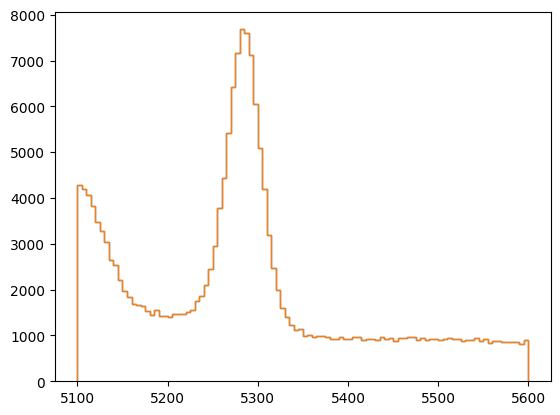

In [11]:
invariant_mass_numpy = np.where((
        invariant_mass_numpy > 5100) & (
        invariant_mass_numpy < 5600), invariant_mass_numpy, np.nan)
plt.hist(invariant_mass_numpy, bins=100,  histtype='step', label='Invariant Mass');
values, bins, patches = plt.hist(invariant_mass_numpy, bins=100,  histtype='step', label='Invariant Mass');


In [12]:

#fit a gaussian to the dataset 
def gaussian(x, norm, mean, sigma):
    return np.array( (1 / sigma) * norm * np.exp( -0.5 * ( (x-mean)/sigma )**2 ) )
def exponential(x, norm, decay, xoffset):
# this is a technical parameter, which can be used to move the position at which the function evaluates to "norm"
    return np.array( (1 / decay )  * norm * np.exp(-(x-xoffset)/decay) )
def constant(x, norm):
    return np.array( norm * np.ones(len(x)) )

def half_gaussian(x, norm, mean, sigma):
    return np.array( (1 / sigma) * norm * np.exp( -0.5 * ( (x-mean)/sigma )**2 ) * (x > mean) )



In [13]:
def fit_func(x, norm, mean, sigma):
    return np.array( gaussian(x, norm, mean, sigma) )
def fit_func_triple(x, norm1, mean1, sigma1, norm2, mean2, sigma2, normE, decayE):
    return np.array(gaussian(x, norm1, mean1, sigma1) + gaussian(x, norm2, mean2, sigma2)  + exponential(x, normE, decayE))

def fit_func_quad(x, norm1, mean1, sigma1, norm2, mean2, sigma2, normE, decayE, constant):
    return np.array(gaussian(x, norm1, mean1, sigma1) + gaussian(x, norm2, mean2, sigma2) + exponential(x, normE, decayE) + constant(x, constant))

def fit_func_trip_gauss(x, norm1, mean1, sigma1, norm2, mean2, sigma2, norm3, mean3, sigma3):
    return np.array(gaussian(x, norm1, mean1, sigma1) + gaussian(x, norm2, mean2, sigma2) + gaussian(x, norm3, mean3, sigma3))

def fit_func_half(x, norm1, mean1, sigma1, norm2, mean2, sigma2, normE, decayE,
                  offsetE):
    return np.array(half_gaussian(x, norm1, mean1, sigma1) +
                    gaussian(x, norm2, mean2, sigma2) +
                    exponential(x, normE, decayE, offsetE))


In [14]:
# popt, pcov = curve_fit(fit_func_triple, get_bins(bins, values), values, 
#                         p0 = [1000, 4100, 5, 1000, 5400, 40, 10, 5 ])

# popt_triple, pcov_triple = curve_fit(fit_func_trip_gauss, get_bins(bins, values), values,
#                             p0 = [1000, 4100, 5, 1000, 5200, 10,1000, 5800, 100
#                                  ])

# y_data = fit_func_trip_gauss(x_data, popt_triple[0], popt_triple[1], popt_triple[2],
#                          popt_triple[3], popt_triple[4], popt_triple[5], popt_triple[6],
#                          popt_triple[7], popt_triple[8])

popt, pcov = curve_fit(fit_func_half, get_bins(bins, values), values,
                        p0 = [1000, 5100, 5, 1000, 5300, 10, 10, 5, 5100 ],
                        maxfev=1000000)
print(popt)

y_data = fit_func_half(x_data, popt[0], popt[1], popt[2],
                        popt[3], popt[4], popt[5],
                        popt[6], popt[7], popt[8])

[ 5.08253333e+14  3.15439242e+03  3.08511413e+02  1.29684320e+05
  5.28403468e+03  1.99520796e+01 -5.73189361e+11 -1.39957521e+11
 -7.60141922e+11]


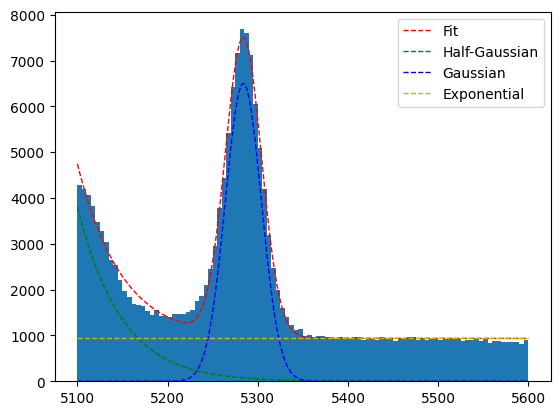

In [15]:
y_plot_1 = half_gaussian(x_data, popt[0], popt[1], popt[2])
y_plot_2 = gaussian(x_data, popt[3], popt[4], popt[5])
y_plot_3 = exponential(x_data, popt[6], popt[7], popt[8])

plt.hist(invariant_mass_numpy, bins=BIN_NUM)
plt.plot(x_data, y_data, color='r', linestyle='dashed', linewidth=1, label='Fit')
plt.plot(x_data, y_plot_1, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2, color='b', linestyle='dashed', linewidth=1, label='Gaussian')
plt.plot(x_data, y_plot_3, color='y', linestyle='dashed', linewidth=1, label='Exponential')
plt.legend()

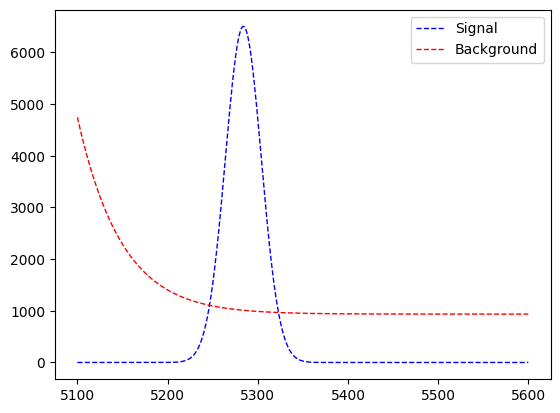

In [16]:
plt.plot(x_data, y_plot_2, color='b', linestyle='dashed', linewidth=1, label='Signal')
plt.plot(x_data, y_data-y_plot_2, color='r', linestyle='dashed', linewidth=1, label='Background')
plt.legend()


In [17]:
#numerically integrate the signal using the x_data 
#and the y_data from the fit
signal_integral = np.trapz(y_data, x_data)


In [18]:
signal = y_plot_2
background = y_data - signal
def clean_data(y_data, y_other):

    for y_indivual in y_other:
        y_data = y_data - y_indivual
    
    return y_data

def significance_calc(signal, background, x_data_subsection):
    # find the area under the signal curve
    signal_integral = np.trapz(signal, x_data_subsection)
    background_integral = np.trapz(background, x_data_subsection)
    return signal_integral / np.sqrt(background_integral + signal_integral)


def optimise_significance(x_data, signal, background, x_min, x_max, p0=[5200, 5300]):
    
    #find the first index of the x_min that is greater than the x_min value

    x_min_index = np.argmax(x_data > x_min)
    x_max_index = np.argmin(x_data < x_max)
    x_data_subsection = x_data[x_min_index:x_max_index]
    signal_subsection = signal[x_min_index:x_max_index]
    background_subsection = background[x_min_index:x_max_index]
    #calculate the significance
    significance_val = significance_calc(signal_subsection, background_subsection, x_data_subsection)
    return significance_val

# find the maximum significance for the different x_min and x_max values

x_min = 5200
x_max = 5600

#optimise the significance for the different x_min and x_max values
best_significance = 0
iterations =  500

x_min_array = []
x_max_array = []

for i in range(iterations):

    curr_xmin = x_min + i

    for j in range(iterations):
        curr_xmax = x_max - j
        if curr_xmax < curr_xmin:
            break
        significance_new = optimise_significance(
            x_data, signal, background, curr_xmin, curr_xmax)
        
        if significance_new > best_significance:
            best_significance = significance_new

            x_min_opt = curr_xmin
            x_max_opt = curr_xmax

print("Optimal x_min: ", x_min_opt)
print("Optimal x_max: ", x_max_opt)
print("Optimal significance: ", best_significance)


/tmp/ipykernel_1151/4084436457.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return signal_integral / np.sqrt(background_integral + signal_integral)


Optimal x_min:  5242
Optimal x_max:  5328
Optimal significance:  496.29834152850975


456


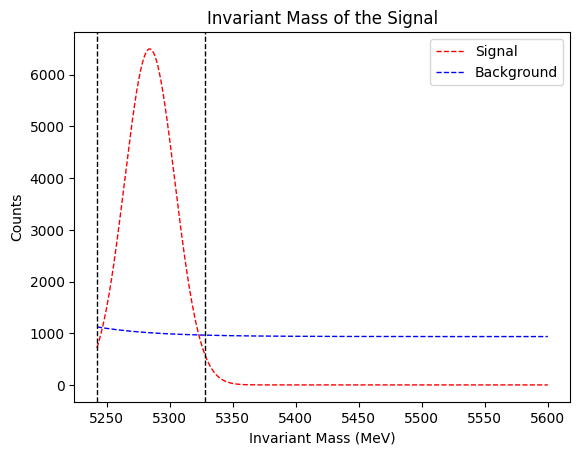

In [19]:
arg_min = np.argmax(x_data > x_min_opt)
arg_max = print(np.argmin(x_data < x_max_opt))
plt.plot(x_data[arg_min:arg_max], signal[arg_min:arg_max], color='r',
          linestyle='dashed', linewidth=1, label='Signal')
plt.plot(x_data[arg_min:arg_max], background[arg_min:arg_max], color='b',
            linestyle='dashed', linewidth=1, label='Background')
plt.xlabel('Invariant Mass (MeV)')
plt.ylabel('Counts')
plt.title('Invariant Mass of the Signal')
#vertical lines to show the x_min and x_max values

plt.axvline(x=x_min_opt, color='k', linestyle='dashed', linewidth=1)
plt.axvline(x=x_max_opt, color='k', linestyle='dashed', linewidth=1)
plt.legend()

Text(0.5, 1.0, 'Residuals of B-')

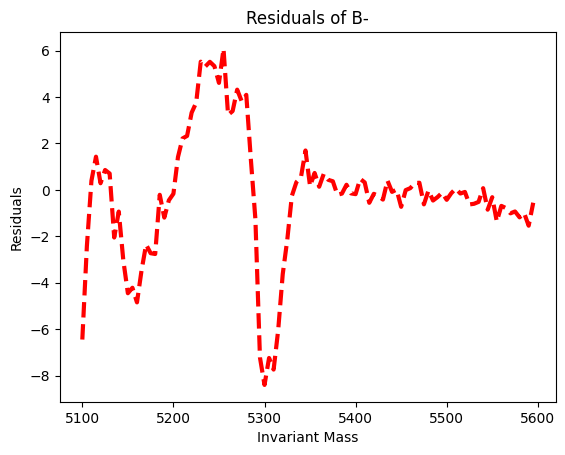

In [21]:
# Residuals for entire dataset

binned_fititng = fit_func_half(bins[:-1], popt[0], popt[1], popt[2],
                                   popt[3], popt[4], popt[5],
                                   popt[6], popt[7], popt[8])

residuals = values - binned_fititng

plt.figure()
plt.plot(bins[:-1], residuals/ np.sqrt(bins[:-1]), color='r', linestyle='dashed', linewidth=3, label='Residuals')
plt.xlabel("Invariant Mass")
plt.ylabel("Residuals")
plt.title("Residuals of B-")

## B+/B- Decay


In [22]:

    

general_bins, general_values, general_patches, general_array = get_bins_values(mode="general", BINS=BIN_NUM, x_min=5100, x_max=5800, 
                                                                              data_generation=2)        
positive_bins, positive_values, positive_patches, positive_array = get_bins_values(mode="B+", BINS=BIN_NUM, x_min=5100, x_max=5800)
negative_bins, negative_values, negative_patches, negative_array = get_bins_values(mode="B-", BINS=BIN_NUM, x_min=5100, x_max=5800)

popt, pcov = curve_fit(fit_func, get_bins(general_bins, general_values),
 general_array, p0 = [1000, 5100, 5, 1000, 5200, 10, 10, 5, 5100 ],
    maxfev=10000)
popt_pve, pcov_pve = curve_fit(fit_func_half, get_bins(positive_bins, positive_values),
                                positive_values, p0 = [1000, 5100, 5, 1000, 5200, 10, 10, 5, 5100 ],
                                                                                maxfev=10000)
print(popt_pve)

popt_nve , pcov_nve = curve_fit(fit_func_half, get_bins(negative_bins, negative_values), negative_values,
                        p0 = [1000, 5100, 5, 1000, 5300, 10, 10, 5, 5100 ],
                        maxfev=100000)

y_data_pve = fit_func_half(x_data, popt_pve[0], popt_pve[1], popt_pve[2],
                        popt_pve[3], popt_pve[4], popt_pve[5],
                        popt_pve[6], popt_pve[7], popt_pve[8])
y_data_nve = fit_func_half(x_data, popt_nve[0], popt_nve[1], popt_nve[2],
                        popt_nve[3], popt_nve[4], popt_nve[5],
                        popt_nve[6], popt_nve[7], popt_nve[8])
#CALCULATE THE CHI SQUARED VALUE OF EACH FIT




ValueError: array must not contain infs or NaNs

In [104]:
#discard last value of positve bins 


In [14]:
binned_fititng_pve = fit_func_half(positive_bins[:-1], popt_pve[0], popt_pve[1], popt_pve[2],
                                   popt_pve[3], popt_pve[4], popt_pve[5],
                                   popt_pve[6], popt_pve[7], popt_pve[8])
binned_fititng_nve = fit_func_half(negative_bins[:-1], popt_nve[0], popt_nve[1], popt_nve[2],
                                      popt_nve[3], popt_nve[4], popt_nve[5],                                                
                                        popt_nve[6], popt_nve[7], popt_nve[8])

print(np.shape(binned_fititng_nve))
binned_fititng_nve
residual_pve = positive_values - binned_fititng_pve
residual_nve = negative_values - binned_fititng_nve

(100,)


Text(0.5, 1.0, 'Invariant Mass of B+')

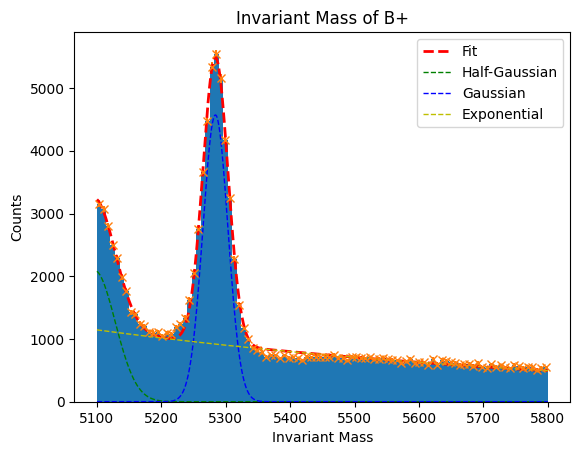

In [110]:
y_plot_1_pve = half_gaussian(x_data, popt_pve[0], popt_pve[1], popt_pve[2])
y_plot_2_pve = gaussian(x_data, popt_pve[3], popt_pve[4], popt_pve[5])
y_plot_3_pve = exponential(x_data, popt_pve[6], popt_pve[7], popt_pve[8])

plt.hist(positive_array, bins=BIN_NUM)
# add errors to the histogram 
# get number of counts in each bin

def bin_contents(patches):
    bin_contents = []
    for i in range(len(patches)):
        bin_contents.append(patches[i].get_height())
    return bin_contents
positive_bin_content = bin_contents(positive_patches)
plt.errorbar(get_bins(positive_bins, positive_values), positive_values, yerr=np.sqrt(positive_bin_content), fmt='x')

plt.plot(x_data, y_data_pve, color='r', linestyle='dashed', linewidth=2, label='Fit')
plt.plot(x_data, y_plot_1_pve, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2_pve, color='b', linestyle='dashed', linewidth=1, label='Gaussian')
plt.plot(x_data, y_plot_3_pve, color='y', linestyle='dashed', linewidth=1, label='Exponential')
plt.legend()


plt.xlabel("Invariant Mass")
plt.ylabel("Counts")
plt.title("Invariant Mass of B+")

Text(0.5, 1.0, 'Residuals of B+')

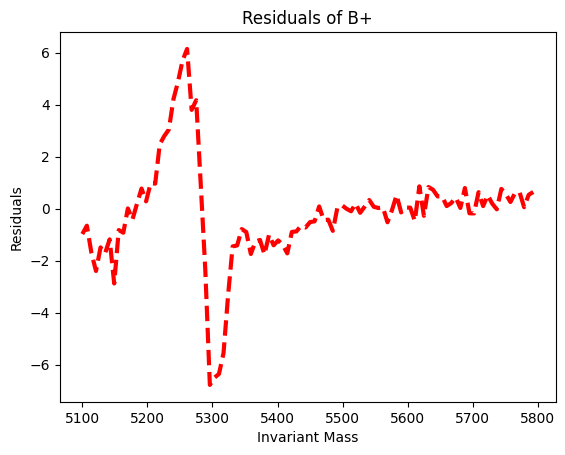

In [114]:
#plot the residuals
plt.figure()
#using the bin centeres calculate the residuals

plt.plot(positive_bins[:-1], residual_pve/ np.sqrt(positive_bins[:-1]), color='r', linestyle='dashed', linewidth=3, label='Residuals')
plt.xlabel("Invariant Mass")
plt.ylabel("Residuals")
plt.title("Residuals of B+")


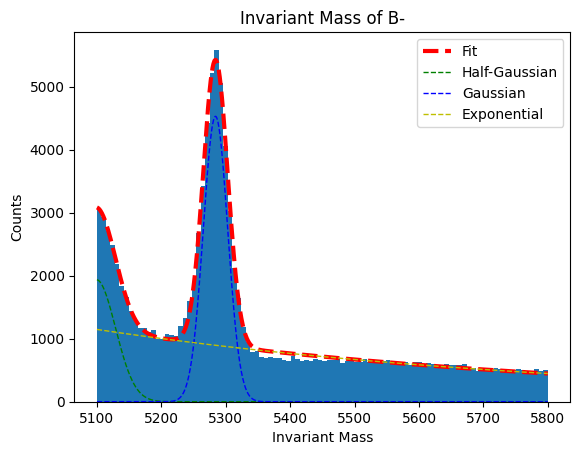

In [108]:


y_plot_1_nve = half_gaussian(x_data, popt_nve[0], popt_nve[1], popt_nve[2])
y_plot_2_nve = gaussian(x_data, popt_nve[3], popt_nve[4], popt_nve[5])
y_plot_3_nve = exponential(x_data, popt_nve[6], popt_nve[7], popt_nve[8])

plt.hist(negative_array, bins=BIN_NUM)
plt.plot(x_data, y_data_nve, color='r', linestyle='dashed', linewidth=3, label='Fit')
plt.plot(x_data, y_plot_1_nve, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2_nve, color='b', linestyle='dashed', linewidth=1, label='Gaussian')
plt.plot(x_data, y_plot_3_nve, color='y', linestyle='dashed', linewidth=1, label='Exponential')

plt.xlabel("Invariant Mass")
plt.ylabel("Counts")
plt.title("Invariant Mass of B-")
plt.legend()

Text(0.5, 1.0, 'Residuals of B-')

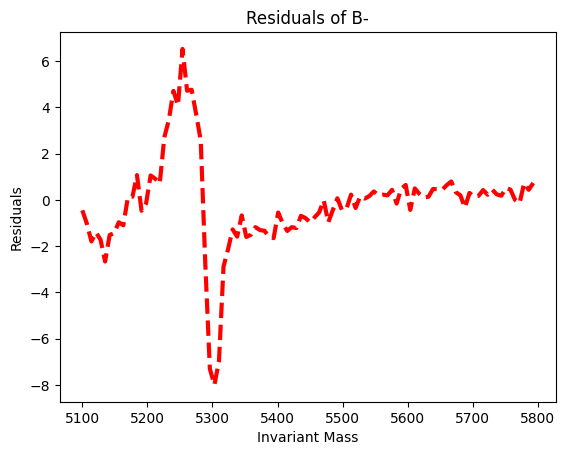

: 

In [115]:
#residuals for negative
plt.figure()
plt.plot(negative_bins[:-1], residual_nve/ np.sqrt(negative_bins[:-1]), color='r', linestyle='dashed', linewidth=3, label='Residuals')
plt.xlabel("Invariant Mass")
plt.ylabel("Residuals")
plt.title("Residuals of B-")


Fitting parameters for entire dataset: p0 = [100, 5000, 4, 100, 5200, 5, 10, 1000 ])
subset: -> with 4500

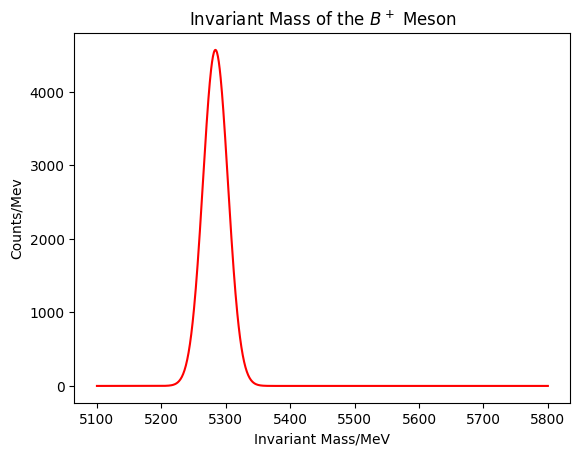

In [42]:
y_signal_pve = clean_data(y_data_pve, [y_plot_1_pve, y_plot_3_pve])

y_signal_nve = clean_data(y_data_nve, [y_plot_1_nve, y_plot_3_nve])

plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of the $B^+$ Meson')
plt.plot(x_data, y_signal_pve, 'r-', label='fit')

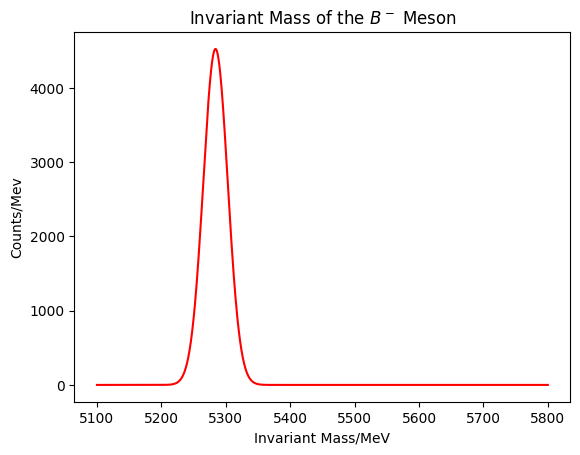

In [43]:
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of the $B^-$ Meson')
plt.plot(x_data, y_signal_nve, 'r-', label='fit')

In [44]:
def area_under_curve(x_data, y_data):
    area = np.trapz(y_data, x_data)
    #find area using monte carlo method
    
    return area
#find area under a histogram using monte carlo method
def area_monte(x_data, y_data):
    return 0

area_pve = area_under_curve(x_data, y_signal_pve)
area_nve = area_under_curve(x_data, y_signal_nve)
print(f"The area under the curve is {area_pve:g} which is the count rate of the signal.")
print(f"The area under the curve is {area_nve:g} which is the count rate of the signal.")

The area under the curve is 222178 which is the count rate of the signal.
The area under the curve is 214503 which is the count rate of the signal.


100,000 events cleaned initial, seed = 0. Leads to 9332.89  area under the curve for B+
100,000 events cleaned initial, seed = 0. Leads to 9045.72 area under the curve for B-


In [47]:
N_plus = area_pve
N_minus =  area_nve

A = (N_plus - N_minus) / (N_plus + N_minus)
unc_assymetry = np.sqrt( 1- A ** 2) / np.sqrt(N_plus + N_minus)
print(f" The CP asymmetry is {A:g} +/- {unc_assymetry:g}.")



 The CP asymmetry is 0.017576 +/- 0.00151304.


In [46]:


def find_indivual(x_data, min=4000, max=6500, name="Inv_mass_Positive"):
    x_data = np.array(x_data)
    inv_mass = (np.where((x_data > min) & (x_data < max), x_data, np.nan))
    plt.hist(inv_mass, bins=100, histtype='step', label=name);   
    values, bins, patches = plt.hist(inv_mass, bins=100)
    x_data = np.linspace(4000, 6000, 100)

    popt, pcov = curve_fit(fit_func_triple, get_bins(bins, values), values, 
                            p0 = [100, 5000, 40, 100, 5300, 5, 10, 1000 ])
    y_data = fit_func_triple(x_data, popt[0], popt[1], popt[2], popt[3], popt[4],
                              popt[5], popt[6], popt[7])

    #take difference between 5271 and the mean of the gaussian fit
    #if the difference is positive, then the signal is positive

    y_plot_1_diff = np.abs(5271 - popt[1])
    y_plot_2_diff = np.abs(5271 - popt[4])

   
    y_plot_1 = gaussian(x_data, popt[0], popt[1], popt[2])
    y_plot_2 = gaussian(x_data, popt[3], popt[4], popt[5])
    y_plot_3 = exponential(x_data, popt[6], popt[7])
    #plot the data

    plt.plot(x_data, y_data, 'r-', label='fit')
    plt.plot(x_data, y_plot_1, 'b-', label='fit')
    plt.plot(x_data, y_plot_2, 'g-', label='fit')
    plt.plot(x_data, y_plot_3, 'y-', label='fit')

    if abs(y_plot_1_diff) < abs(y_plot_2_diff):
        other_dataaset = [y_plot_2, y_plot_3]
    else:
        other_dataaset = [y_plot_1, y_plot_3]


    y_signal = clean_data(y_data, other_dataaset)

    plt.xlabel('Invariant Mass/MeV' + name)
    plt.ylabel('Counts/Mev')
    plt.title('Invariant Mass of the $B^+/-$ Meson' + name)
    plt.plot(x_data, y_signal, 'r-', label='fit')

    return y_signal

def assymetry_func(positve_data, negative_data):
    A = (positve_data - negative_data) / (positve_data + negative_data)
    return A

def find_assymetry(data_mode=3, MAX_EVENTS=1, num_repetitions=1):
    
    pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (
    master_probpi, master_probk), inv_mass_positive = read_file(mode=data_mode, MAX_EVENTS=MAX_EVENTS, selection=True,
                                                                   interest="B+")
    del pT, pX, pY, pZ, h1_probpi, h1_probk, h2_probpi, h2_probk, h3_probpi, h3_probk, master_probpi, master_probk

    #take B- data
    pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (
    master_probpi, master_probk), inv_mass_negative = read_file(mode=data_mode, MAX_EVENTS=MAX_EVENTS, selection=True,
                                                                     interest="B-")
    
    del pT, pX, pY, pZ, h1_probpi, h1_probk, h2_probpi, h2_probk, h3_probpi, h3_probk, master_probpi, master_probk

    positive_area = []
    negative_area = []

    #randomly sample 3 integers from 1 to million

    random_integers = np.random.randint(1, 1000000, num_repetitions)
    
    for i in random_integers:
        np.random.seed(i)
        plt.hist(inv_mass_positive, bins=100,  histtype='step', label='Invariant Mass');
        positive_area.append(find_indivual(inv_mass_positive, name="Inv_mass_Positive"))
        del inv_mass_positive
        negative_area.append(find_indivual(inv_mass_negative, name="Inv_mass_Negative"))
        del inv_mass_negative
    positive_area_mean = np.mean(positive_area)
    negative_area_mean = np.mean(negative_area)
    print(positive_area_mean, negative_area_mean)
    assymetry = assymetry_func(positive_area_mean, negative_area_mean)
    print(f"The assymetry is given by {assymetry}")
    return assymetry

find_assymetry(data_mode=2, MAX_EVENTS=10000, num_repetitions=1)


 Selecting B+ events
Input data varaiables: 
Magnet down data
['DecayTree;1']
Varialbes read



  0%|          | 0/10000 [00:00<?, ?it/s]

Read 10004 events


ValueError: too many values to unpack (expected 9)

In [67]:
# #fit a gaussian mixture model to the invariant mass data
# def fit_data(bins,values,low,high,guess):
#     # get the bin centres
#     bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ]
#     # get the bin centres in the range we want to fit
#     bin_centres_red = [x for x in bin_centres if x > low and x < high]
#     # get the values in the range we want to fit
#     values_red = [x for x,y in zip(values,bin_centres) if y > low and y < high]
#     # fit the data
#     coeff_fit, cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0=guess)
#     # calculate chi2
#     chi2 = np.sum(((values_red - fit_function(bin_centres_red,coeff_fit[0],coeff_fit[1],coeff_fit[2]))/np.sqrt(values_red))**2)
#     # calculate ndf
#     ndf = len(values_red) - 3
#     return coeff_fit, cov_fit, bin_centres, bin_centres_red, chi2, ndf

# def print_results(coeff,cov,chi2,ndf):
#     print('chi2 = ', chi2)
#     print('ndf = ', ndf)
#     print('chi2/ndf = ', chi2/ndf)
#     print('norm = ', coeff[0])
#     print('mean = ', coeff[1])
#     print('std = ', coeff[2])
#     print('cov = ', cov)

# def plot_results(ax,bin_centres,bin_centres_red,values,coeff,filename):
#     ax.hist(bin_centres, bins=100, weights=values, histtype='step', label='Invariant Mass');
#     ax.plot(bin_centres_red, fit_function(bin_centres_red,coeff[0],coeff[1],coeff[2]), 'r-', label='fit')
#     ax.set_xlabel('Invariant Mass [MeV]')
#     ax.set_ylabel('Counts')
#     ax.legend()
#     plt.savefig(filename)


# 2 Body Resonance Removal


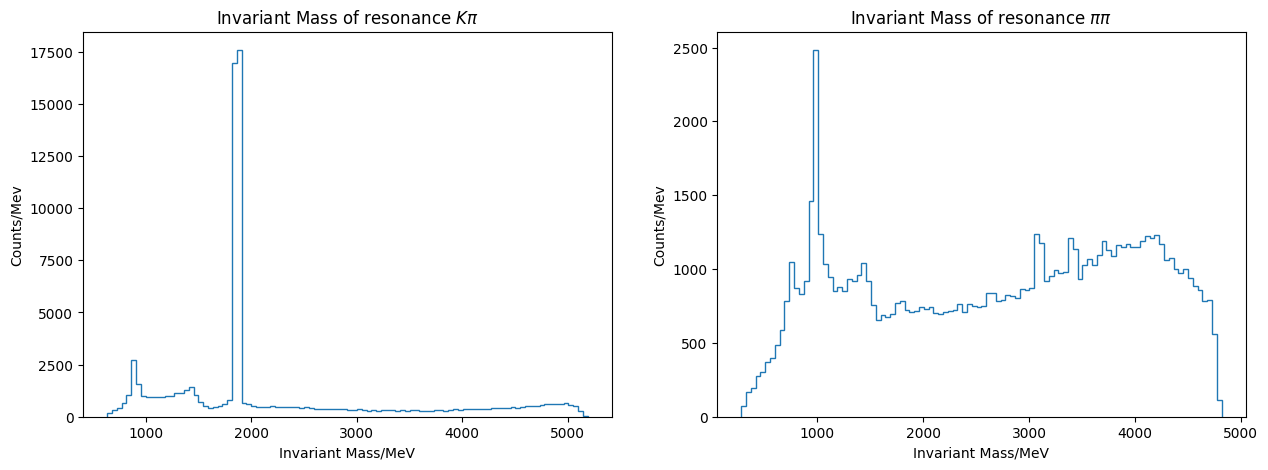

In [71]:
two_body_resonance = np.genfromtxt('/workspaces/labs_yr3/two_body_resonance.csv', delimiter=',')
#plot two figures side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(two_body_resonance[:,0], bins=100,  histtype='step', label='Invariant Mass');
ax1.set_title('Invariant Mass of resonance $K \pi$')
ax1.set_xlabel('Invariant Mass/MeV')
ax1.set_ylabel('Counts/Mev')
ax2.set_title('Invariant Mass of resonance $\pi \pi$')
ax2.set_xlabel('Invariant Mass/MeV')
ax2.set_ylabel('Counts/Mev')
ax2.hist(two_body_resonance[:,1], bins=100,  histtype='step', label='Invariant Mass');
#plot two histograms for each of the two body resonances


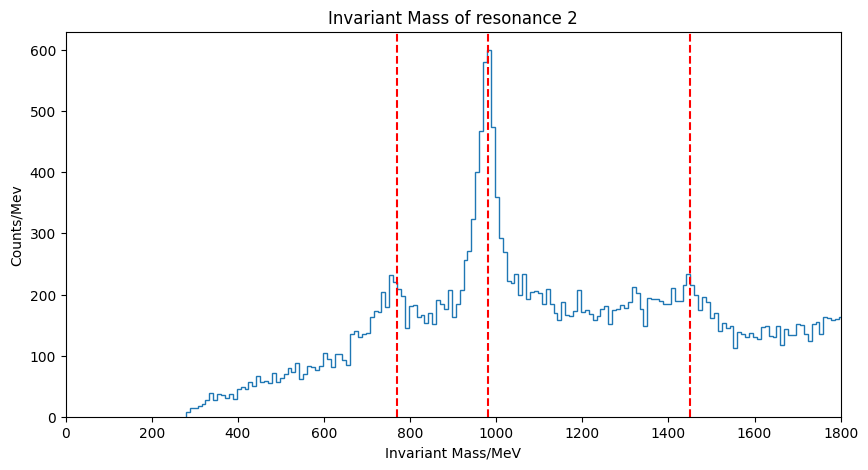

In [72]:
#change figure size
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,1], bins=500,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(0, 1800)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance 2')
#set a vertical line at the peak of the histogram
plt.axvline(x=770, color='r', linestyle='--')
plt.axvline(x=980, color='r', linestyle='--')
plt.axvline(x=1450, color='r', linestyle='--')

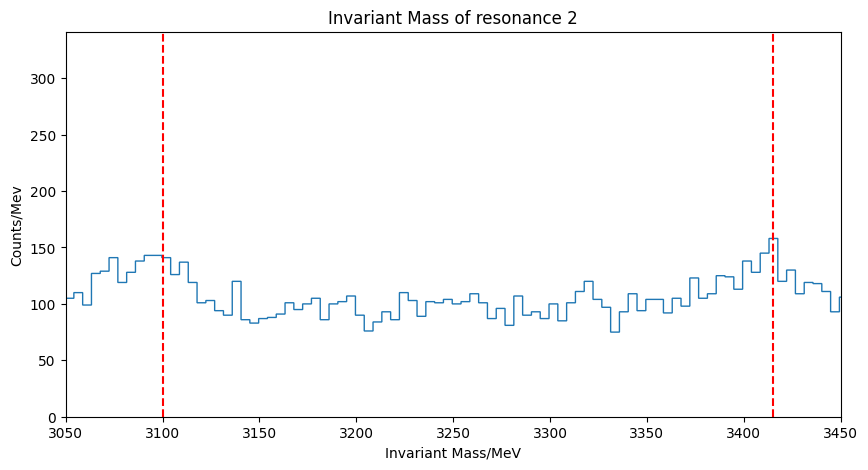

In [73]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,1], bins=1000,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(3050, 3450)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance 2')
#set a vertical line at the peak of the histogram
plt.axvline(x=3100, color='r', linestyle='--')
plt.axvline(x=3415, color='r', linestyle='--')
plt.axvline(x=1450, color='r', linestyle='--')

Other resonance plot

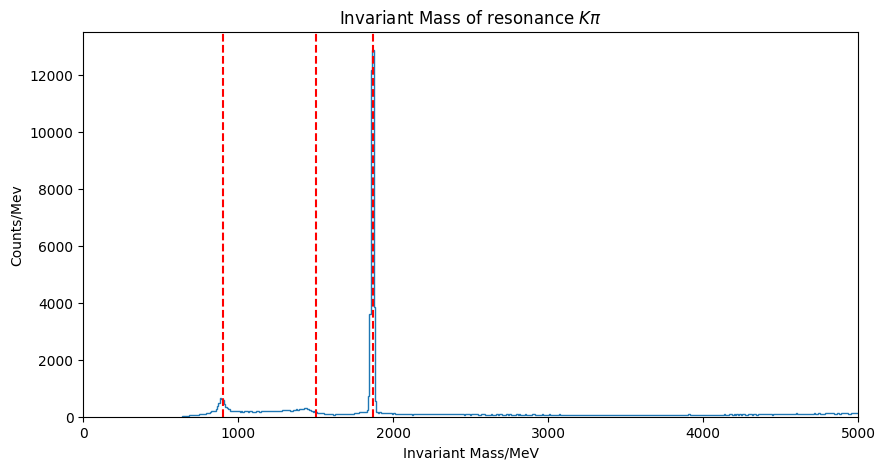

In [74]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,0], bins=500,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(0, 5000)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance $K \pi$')
plt.axvline(x=900, color='r', linestyle='--')
plt.axvline(x=1500, color='r', linestyle='--')
plt.axvline(x=1870, color='r', linestyle='--')

#set a vertical line at the peak of the histogram
#plt.axvline(x=770, color='r', linestyle='--')
#plt.axvline(x=980, color='r', linestyle='--')
#plt.axvline(x=1450, color='r', linestyle='--')

(0.0, 1200.0)

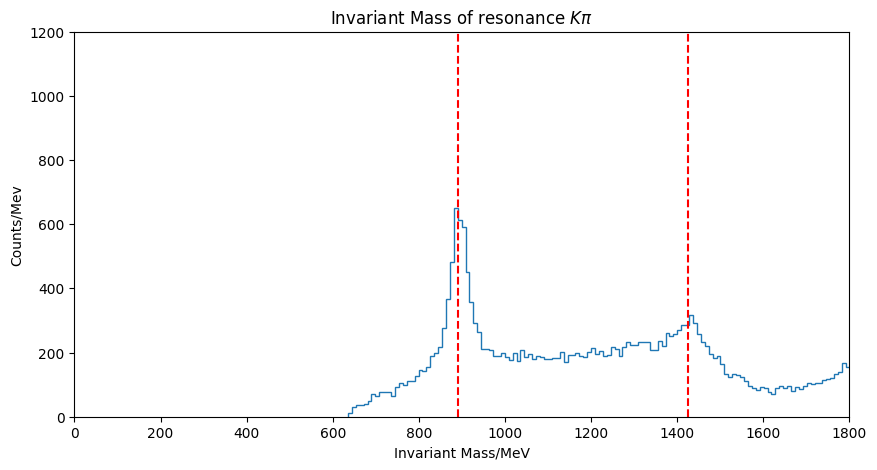

In [75]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,0], bins=500,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(0, 1800)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance $K \pi$')
plt.axvline(x=890, color='r', linestyle='--')
plt.axvline(x=1425, color='r', linestyle='--')
#plt.axvline(x=1870, color='r', linestyle='--')
plt.ylim(0, 1200)
#set a vertical line at the peak of the histogram
#plt.axvline(x=770, color='r', linestyle='--')
#plt.axvline(x=980, color='r', linestyle='--')
#plt.axvline(x=1450, color='r', linestyle='--')

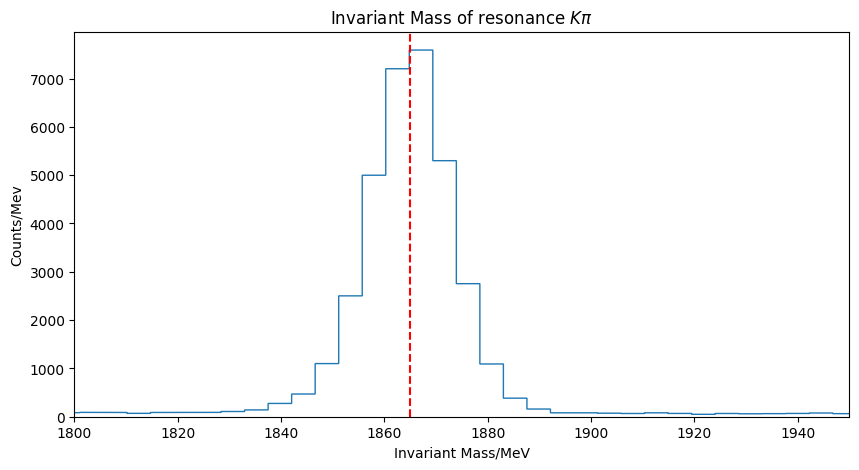

In [76]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,0], bins=1000,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(1800, 1950)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance $K \pi$')
#plt.axvline(x=890, color='r', linestyle='--')
#plt.axvline(x=1425, color='r', linestyle='--')
plt.axvline(x=1865, color='r', linestyle='--')
#plt.ylim(0, 1200)

(0.0, 300.0)

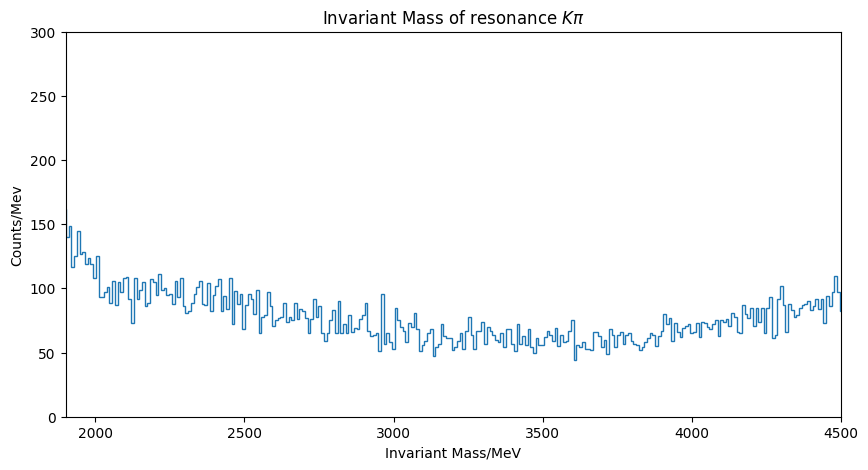

In [77]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,0], bins=500,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(1900, 4500)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance $K \pi$')
#plt.axvline(x=890, color='r', linestyle='--')
#plt.axvline(x=1425, color='r', linestyle='--')
plt.axvline(x=1865, color='r', linestyle='--')
plt.ylim(0, 300)

# Removing Plots

# Dalitz Plots 

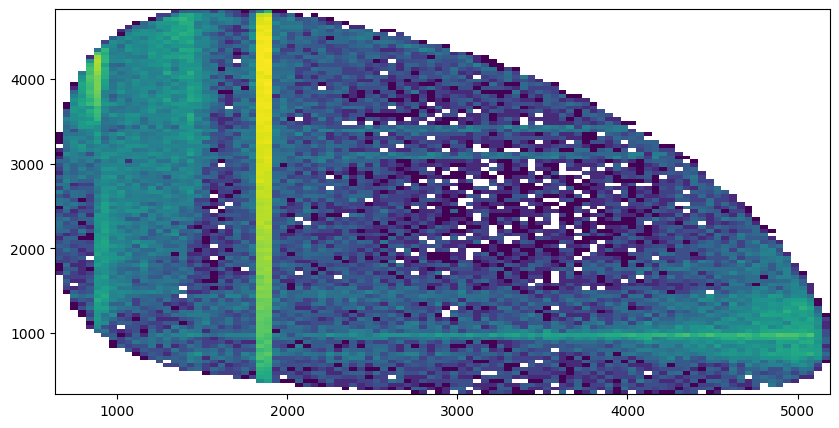

In [70]:
plt.figure(figsize=(10, 5))
plt.hist2d(two_body_resonance[:,0], two_body_resonance[:,1],
          bins=100,   label='Invariant Mass',
          norm=colors.LogNorm());


### Manipulation of 2D histograms

The following is an example code to demonstrate manipulation of the content of 2D histograms. It first produces two dummy histograms before working out the bin centres, subtracting the histogram contents, and finally plotting. The subtraction bit can of course be replaced by more complex operations as well.

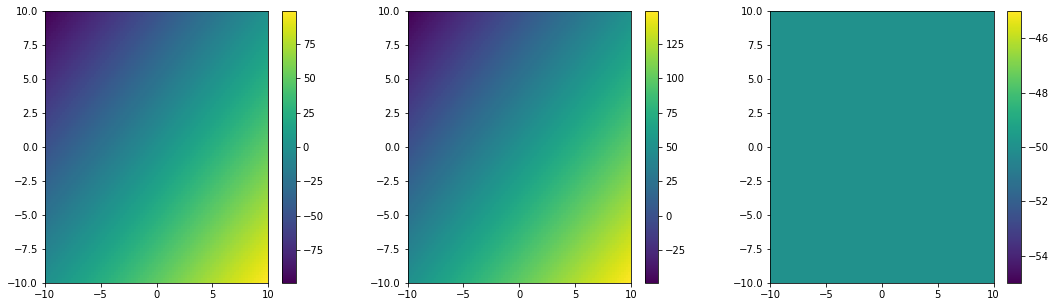

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

### ignore this bit and replace by however you produce your two 2D histograms to be subtracted ###
xvalues = []
yvalues = []
weights1 = []
weights2 = []
for x in range(100):
    for y in range(100):
        xvalues.append(-10+x/5.+0.1) # bin centre for x
        yvalues.append(-10+y/5.+0.1) # bin centre for y
        weights1.append((x-y))       # weights for histo1, this would be filled automatically
        weights2.append((x-y)+50)    # weights for histo2
h2d1 = ax[0].hist2d(xvalues,yvalues,weights=weights1,bins = [100,100], range = [[-10,10],[-10,10]])        
h2d2 = ax[1].hist2d(xvalues,yvalues,weights=weights2,bins = [100,100], range = [[-10,10],[-10,10]])
### end ignoring here :) ###

# first calculate the bin centres from the bin boundaries of the hist2d object
xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
wsub = np.subtract(w1,w2) # subtract bin content of two histograms

# produce the new histogram
h2d3 = ax[2].hist2d(xcentres,ycentres,weights=wsub, bins = [h2d1[1],h2d1[2]]) # recycle the binning from above

# plot the lot
fig.colorbar(h2d1[3],ax=ax[0]) # let's add the colour scale for histo 1
fig.colorbar(h2d2[3],ax=ax[1]) # let's add the colour scale for histo 2
fig.colorbar(h2d3[3],ax=ax[2]) # let's add the colour scale for histo 3